# Classifying the Result of an English Premier League Football Match

#### Daniel Evans - 3766654

## Table of Contents

- [1. Project Statement](#project)
- [2. The Data](#data)
    - [2.1 Loading Data](#load)
- [3. Date Preprocessing](#preprocessing)
- [4. Data Exploration](#exploration)
    - [4.1 What day are most matches played on?](#matches)
    - [4.2 What is the most commonly occuring matchtime?](#matchtime)
    - [4.3 Which referee has officiated the most matches?](#referee)
    - [4.4 What are the current Premier League Standings?](#standings)
    - [4.5 Which team has the most number of corners?](#corners)
    - [4.6 What are the number of Wins, Losses, and Draws for each team?](#results)
    - [4.7 What are the number of goals scored and conceded for each team?](#goals)
    - [4.8 What are the counts for yellow and red cards for each team?](#cards)
    - [4.9 Are you more likely to gain points at your home ground vs away ground?](#ground)
- [5. Data Modelling](#modelling)
    - [5.1 Data preparation for Scikit learn](#scikit)
    - [5.2 Feature selection and ranking](#selection)
        - [5.2.1 All features](#all)
        - [5.2.2 F score](#fscore)
        - [5.2.3 Mutual](#mutual)
        - [5.2.4 Random Forrest](#forrest)
        - [5.2.5 Performance comparison using paired t-test](#ttest)
    - [5.3 Hyperparameter tuning](#tuning)
        - [5.3.1 KNN](#knn)
        - [5.3.2 DT](#dt)
        - [5.3.3 NB](#nb)
    - [5.4 Performance comparison](#comparison)
- [6. Critique](#critique)
- [7. Summary & Conclusions](#conclusions)

## 1: Project Statement<a name="project"></a>

The aim of this notebook is to construct a model which can accurately classify the result of an English Premier League Football match based on the statistics of the match. Here, the **target feature, ‘result’**, is multinomial. A result can be either win (w), loss (l), or draw (d). 

Note that we are not constructing a model which aims to predict the result of a match yet to be played, rather, a model which accurately classifies the result of a match which has **already** been played. 


## 2: The Data<a name="data"></a>




The full dataset is a merge of two datasets which can be found [here](https://github.com/vaastav/Fantasy-Premier-League) and [here](https://datahub.io/sports-data/english-premier-league)

[1] "Fantasy Premier League", Vaastav Anand, viewed 24th May 2020, 
https://github.com/vaastav/Fantasy-Premier-League

[2] "English Premier League (football)", Datopian, viewed 24th May 2020, 
https://datahub.io/sports-data/english-premier-league

Features:

- h_a: Home or Away
- xG: Expected Goals
- xGA: Expected goals for opposition
- npxG: Expected goals without penalties
- npxGA: Expected goals without penalties for opposition
- deep: passes completed within an estimated 20 yards of goal
- deep_allowed: opponent passes completed within an estimated 20 yards of goal
- scored: number of goals scored
- missed: number of goals conceded
- xpts: Number of expected points
- **result: Result of the match (Target feature)**
- date: date of the match
- wins: Binary for wins
- draws: Binary for draws
- losses: Binary for losses
- pts: Number of points earned for result
- npxGD: difference between "for" and "against" expected goals without penalties and own goals
- teamID: Team name
- ppda_cal: Measure of pressing play (style of play)
- allowed_ppda: Measure of how much opposition allows this style of play
- matchtime: The hour the match took place
- tot_points: Total points the team earned so far
- round: Matchday number
- tot_goal: Total number of goals team has scored so far
- tot_con: Total number of goals team has conceded so far
- Referee.x: Name of the referee
- HS.x: Home team shots
- HST.x: Home team shots on target
- HF.x: Home team fouls
- HC.x: Home team corners
- HY.x: Home team yellow cards
- HR.x: Home team red cards
- AS.x: Away team shots
- AST.x: Away team shots on target
- AF.x: Away team fouls
- AC.x: Away team corners
- AY.x: Away team yellow cards
- AR.x: Away team red cards
- B365H.x: Bet 365 (betting company) odds for home team winning
- B365D.x: Bet 365 odds for a drawn match
- B365A.x: Bet 365 odds for away team winning
- HtrgPerc: Shots on target/Total number of shots for home team
- AtrgPerc: Shots on target/Total number of shots for away team
- matchday: The day of the week the match took place


### 2.1: Load Data<a name="load"></a>

In [187]:
# Import required packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

# Read in data, remove features which aren't required for predictive modelling, and reorder features so that 
# target feature ('result') is the last column
epl = pd.read_csv("epl2020.csv", sep = ',')
epl = epl.drop(columns = ['Unnamed: 0', 'date', 'wins', 'draws', 'loses', 'round'])
epl = epl[['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 
           'xpts', 'pts','npxGD', 'ppda_cal', 'allowed_ppda', 'matchtime', 'tot_points', 'tot_goal',
          'tot_con', 'HS.x', 'HST.x', 'HF.x', 'HC.x', 'HY.x', 'HR.x', 'AS.x', 'AST.x', 'AF.x',
          'AC.x', 'AY.x', 'AR.x', 'B365H.x', 'B365D.x', 'B365A.x', 'HtrgPerc', 'AtrgPerc', 'h_a',
           'teamId', 'Referee.x', 'matchDay', 'result']]
epl.head()

,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,pts,npxGD,ppda_cal,allowed_ppda,matchtime,tot_points,tot_goal,tot_con,HS.x,HST.x,HF.x,HC.x,HY.x,HR.x,AS.x,AST.x,AF.x,AC.x,AY.x,AR.x,B365H.x,B365D.x,B365A.x,HtrgPerc,AtrgPerc,h_a,teamId,Referee.x,matchDay,result
0,2.234560,0.842407,2.234560,0.842407,11,5,4,1,2.3863,3,1.392153,5.942857,21.454545,20,3,4,1,15,7,9,11,0,0,12,5,9,2,2,0,1.14,10.0,19.00,0.466667,0.416667,h,Liverpool,M Oliver,Fri,w
1,0.842407,2.234560,0.842407,2.234560,5,11,1,4,0.4405,0,-1.392153,21.454545,5.942857,20,0,1,4,15,7,9,11,0,0,12,5,9,2,2,0,1.14,10.0,19.00,0.466667,0.416667,a,Norwich,M Oliver,Fri,l
2,3.183770,1.200300,2.422640,1.200300,9,1,5,0,2.6312,3,1.222340,6.935484,16.400000,12,3,5,0,5,3,6,1,2,0,14,9,13,1,2,0,12.00,6.5,1.22,0.600000,0.642857,a,Man City,M Dean,Sat,w
3,1.200300,3.183770,1.200300,2.422640,1,9,0,5,0.2522,0,-1.222340,16.400000,6.935484,12,0,0,5,5,3,6,1,2,0,14,9,13,1,2,0,12.00,6.5,1.22,0.600000,0.642857,h,West Ham,M Dean,Sat,l
4,1.340990,1.598640,1.340990,1.598640,4,6,1,1,1.0172,1,-0.257650,13.600000,9.133333,15,1,1,1,13,3,10,3,2,0,8,3,19,4,1,0,1.95,3.6,3.60,0.230769,0.375000,h,Bournemouth,K Friend,Sat,d


In [2]:
# Dimension of dataset
epl.shape

(576, 39)

#### Talk about the features that were dropped

- features that were not relevant for predictive modelling were removed
- 'deep', 'deep_allowed', and 'npxGD' features meanings are unknown however they may provide good predicting capabalities. This would need to be clarified with the data source. 
- Features such as 'referee' and 'matchday' should not provide much predictive capabilities however there may be small unconcious amounts of bias in certain referees and certain teams may unknowingly play better on certain days. This is why these features were kept. 

## 3: Data Preprocessing<a name="preprocessing"></a>

In [3]:
# Check datatypes correctly loaded
epl.dtypes

xG              float64
xGA             float64
npxG            float64
npxGA           float64
deep              int64
deep_allowed      int64
scored            int64
missed            int64
xpts            float64
pts               int64
npxGD           float64
ppda_cal        float64
allowed_ppda    float64
matchtime         int64
tot_points        int64
tot_goal          int64
tot_con           int64
HS.x              int64
HST.x             int64
HF.x              int64
HC.x              int64
HY.x              int64
HR.x              int64
AS.x              int64
AST.x             int64
AF.x              int64
AC.x              int64
AY.x              int64
AR.x              int64
B365H.x         float64
B365D.x         float64
B365A.x         float64
HtrgPerc        float64
AtrgPerc        float64
h_a              object
teamId           object
Referee.x        object
matchDay         object
result           object
dtype: object

In [4]:
# Check number of missing values
epl.isna().sum()

xG              0
xGA             0
npxG            0
npxGA           0
deep            0
deep_allowed    0
scored          0
missed          0
xpts            0
pts             0
npxGD           0
ppda_cal        0
allowed_ppda    0
matchtime       0
tot_points      0
tot_goal        0
tot_con         0
HS.x            0
HST.x           0
HF.x            0
HC.x            0
HY.x            0
HR.x            0
AS.x            0
AST.x           0
AF.x            0
AC.x            0
AY.x            0
AR.x            0
B365H.x         0
B365D.x         0
B365A.x         0
HtrgPerc        0
AtrgPerc        0
h_a             0
teamId          0
Referee.x       0
matchDay        0
result          0
dtype: int64

In [5]:
# Checking for types, additional whitespace, or unusual values in categorical columns
for col in epl.select_dtypes(include = np.object):
    print(f'Feature: {epl[col].name}')
    print(epl[col].unique())
    print(f'Number of unique values is: {epl[col].nunique()}')
    print('----------------')

Feature: h_a
['h' 'a']
Number of unique values is: 2
----------------
Feature: teamId
['Liverpool' 'Norwich' 'Man City' 'West Ham' 'Bournemouth' 'Brighton'
 'Burnley' 'Crystal Palace' 'Everton' 'Sheffield United' 'Southampton'
 'Watford' 'Aston Villa' 'Tottenham' 'Arsenal' 'Leicester'
 'Newcastle United' 'Wolves' 'Chelsea' 'Man Utd']
Number of unique values is: 20
----------------
Feature: Referee.x
['M Oliver' 'M Dean' 'K Friend' 'C Pawson' 'G Scott' 'J Moss' 'C Kavanagh'
 'M Atkinson' 'A Marriner' 'A Taylor' 'L Mason' 'S Attwell' 'D Coote'
 'O Langford' 'P Tierney' 'A Madley' 'P Bankes' 'S Hooper' 'T Robinson'
 'R Jones' 'S Scott' 'D England']
Number of unique values is: 22
----------------
Feature: matchDay
['Fri' 'Sat' 'Sun' 'Mon' 'Tue' 'Wed' 'Thu']
Number of unique values is: 7
----------------
Feature: result
['w' 'l' 'd']
Number of unique values is: 3
----------------


- Check for unusual values in numerical columns
- Data is already clean/preprocessed

## 4: Data Exploration<a name="exploration"></a>

In [6]:
# Categorical summary statistics
epl.describe(include = np.object)

,h_a,teamId,Referee.x,matchDay,result
count,576,576,576,576,576
unique,2,20,22,7,3
top,h,Norwich,M Atkinson,Sat,l
freq,288,29,50,328,216


In [7]:
# Numerical summary statistics
epl.describe().round(3)

,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,pts,npxGD,ppda_cal,allowed_ppda,matchtime,tot_points,tot_goal,tot_con,HS.x,HST.x,HF.x,HC.x,HY.x,HR.x,AS.x,AST.x,AF.x,AC.x,AY.x,AR.x,B365H.x,B365D.x,B365A.x,HtrgPerc,AtrgPerc
count,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000,576.000
mean,1.460,1.460,1.372,1.372,6.623,6.623,1.361,1.361,1.392,1.375,-0.000,12.302,12.302,15.517,20.443,20.885,20.918,13.778,4.698,10.278,5.962,1.628,0.059,11.417,4.073,10.903,4.917,1.875,0.062,2.867,4.320,4.774,0.348,0.361
std,0.874,0.874,0.801,0.801,4.294,4.294,1.208,1.208,0.869,1.318,1.320,7.371,7.371,2.157,14.292,14.257,12.891,5.478,2.459,3.628,3.265,1.302,0.236,5.154,2.521,3.697,2.794,1.196,0.242,2.276,1.514,4.162,0.155,0.167
min,0.054,0.054,0.054,0.054,0.000,0.000,0.000,0.000,0.000,0.000,-5.525,3.189,3.189,11.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,1.000,0.000,0.000,0.000,1.070,3.100,1.140,0.000,0.000
25%,0.840,0.840,0.784,0.784,4.000,4.000,0.000,0.000,0.637,0.000,-0.873,7.715,7.715,14.000,9.000,9.000,10.000,10.000,3.000,8.000,4.000,1.000,0.000,8.000,2.000,8.000,3.000,1.000,0.000,1.608,3.400,2.300,0.248,0.250
50%,1.275,1.275,1.231,1.231,6.000,6.000,1.000,1.000,1.321,1.000,0.000,10.184,10.184,15.000,18.000,20.000,20.000,13.000,5.000,10.000,5.000,1.000,0.000,11.000,4.000,11.000,5.000,2.000,0.000,2.200,3.750,3.350,0.333,0.333
75%,1.974,1.974,1.869,1.869,9.000,9.000,2.000,2.000,2.139,3.000,0.873,14.439,14.439,17.000,29.000,29.000,30.000,17.000,6.000,13.000,8.000,2.000,0.000,15.000,5.000,13.000,7.000,3.000,0.000,3.100,4.750,5.750,0.444,0.455
max,6.630,6.630,5.869,5.869,31.000,31.000,9.000,9.000,2.999,3.000,5.525,60.000,60.000,20.000,82.000,68.000,56.000,31.000,13.000,21.000,17.000,6.000,1.000,25.000,15.000,24.000,16.000,6.000,1.000,15.000,13.000,26.000,1.000,1.000


### 4.1: What day are most matches played on?<a name="matches"></a>

In [8]:
matchday = epl['matchDay'].value_counts().to_frame().reset_index()
matchday.columns = ['Day', 'Count']
matchday['Count'] = matchday['Count']/2
matchday

,Day,Count
0,Sat,164.0
1,Sun,64.0
2,Wed,20.0
3,Thu,13.0
4,Mon,10.0
5,Fri,9.0
6,Tue,8.0


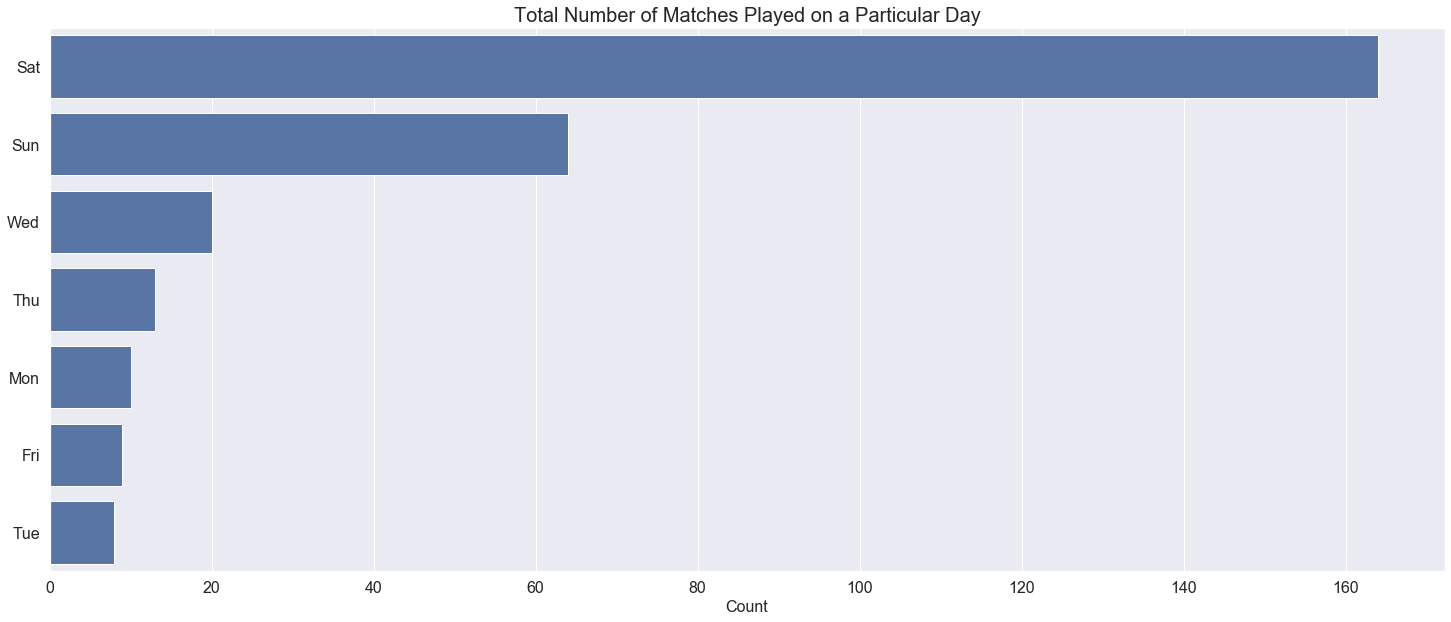

In [186]:
sns.set(rc={'figure.figsize':(25,10)})

ax = sns.barplot(y = "Day", x = "Count", data = matchday, color = 'b')
ax.set_title("Total Number of Matches Played on a Particular Day", fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)
ax.set_ylabel('')
ax.tick_params(labelsize=16)

plt.show()

### 4.2: What is the most commonly occuring matchtime?<a name="matchtime"></a>

In [10]:
time = epl['matchtime'].value_counts().to_frame().reset_index()
time.columns = ['Time', 'Count']
time['Count'] = time['Count']/2
time['Time'] = time['Time'].astype('category')
time

,Time,Count
0,15,109.0
1,14,45.0
2,17,28.0
3,16,28.0
4,12,26.0
5,20,23.0
6,19,22.0
7,13,3.0
8,11,3.0
9,18,1.0


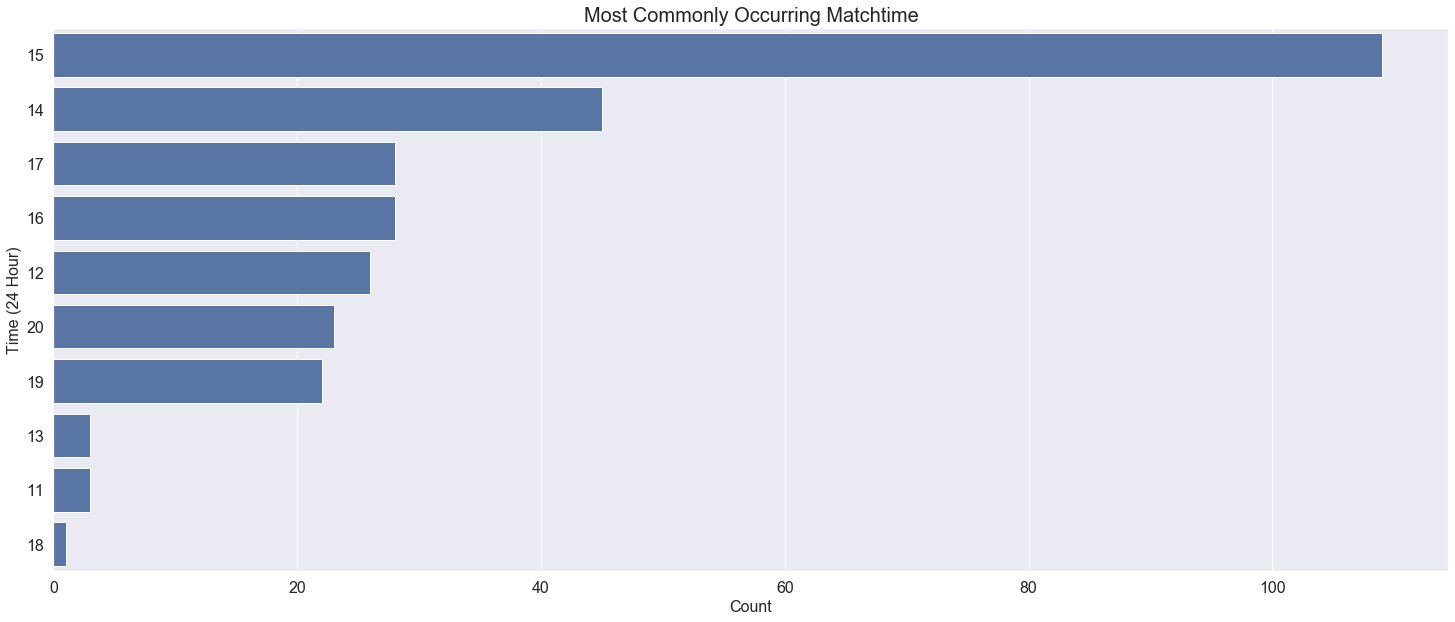

In [185]:
sns.set(rc={'figure.figsize':(25,10)})

order = time['Time'].to_list()

ax = sns.barplot(y = "Time", x = "Count", data = time, color = 'b', order = order)
ax.set_title("Most Commonly Occurring Matchtime", fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)
ax.set_ylabel('Time (24 Hour)', fontsize = 16)
ax.tick_params(labelsize=16)

plt.show()

### 4.3: Which referee has officiated the most matches?<a name="referee"></a>

In [12]:
referee = epl['Referee.x'].value_counts().to_frame().reset_index()
referee.columns = ['Name', 'Count']
referee['Count'] = referee['Count']/2
referee

,Name,Count
0,M Atkinson,25.0
1,A Taylor,23.0
2,M Oliver,23.0
3,M Dean,22.0
4,P Tierney,20.0
5,J Moss,20.0
6,C Kavanagh,20.0
7,K Friend,20.0
8,A Marriner,17.0
9,C Pawson,15.0


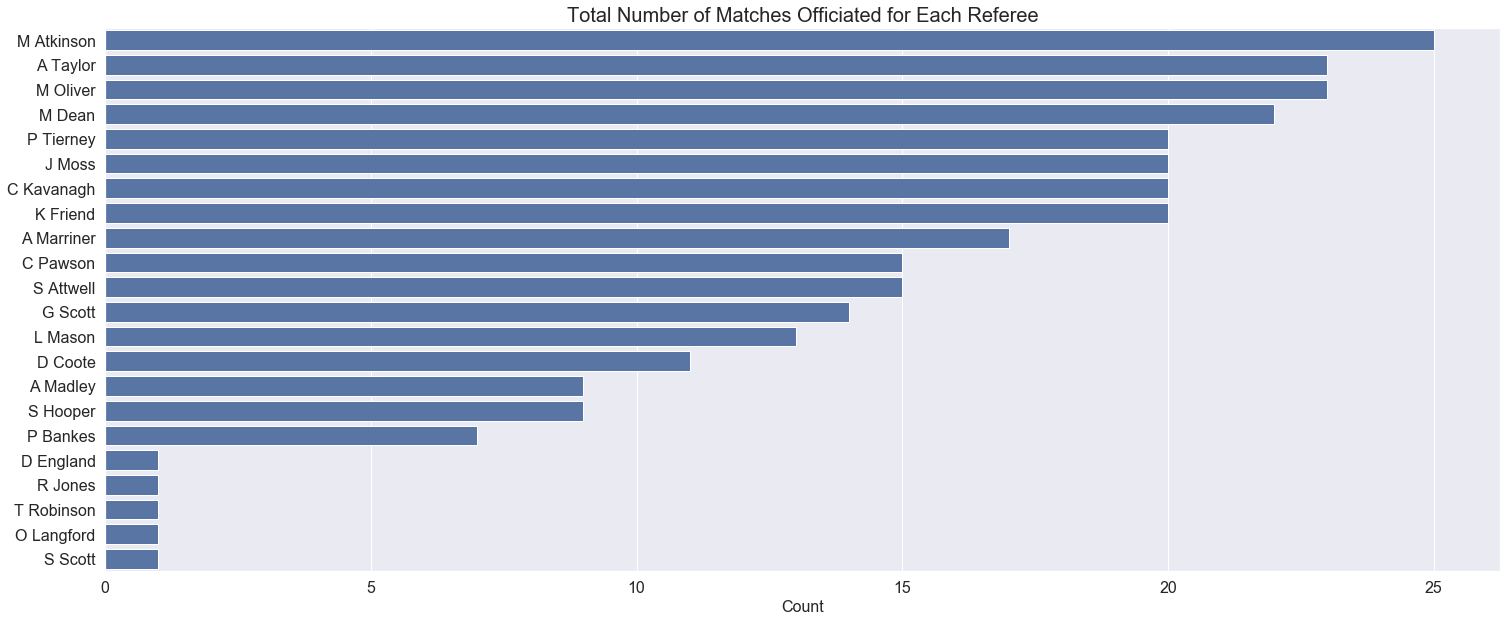

In [184]:
sns.set(rc={'figure.figsize':(25,10)})

ax = sns.barplot(y = "Name", x = "Count", data = referee, color = 'b')
ax.set_title("Total Number of Matches Officiated for Each Referee", fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)
ax.set_ylabel('')
ax.tick_params(labelsize=16)

plt.show()

### 4.4: What are the current Premier League Standings?<a name="standings"></a>

In [14]:
# Current Premier League standings
table = epl.groupby('teamId')['tot_points'].max().to_frame().reset_index().sort_values(
                                                                        by = 'tot_points', ascending = False)
table.reset_index(drop = True, inplace = True)

position = []

for i in range(1,21):
    position.append(i)
    
table['position'] = position
teams = table['teamId'].to_list()
table

,teamId,tot_points,position
0,Liverpool,82,1
1,Man City,57,2
2,Leicester,53,3
3,Chelsea,48,4
4,Man Utd,45,5
5,Sheffield United,43,6
6,Wolves,43,7
7,Tottenham,41,8
8,Arsenal,40,9
9,Crystal Palace,39,10


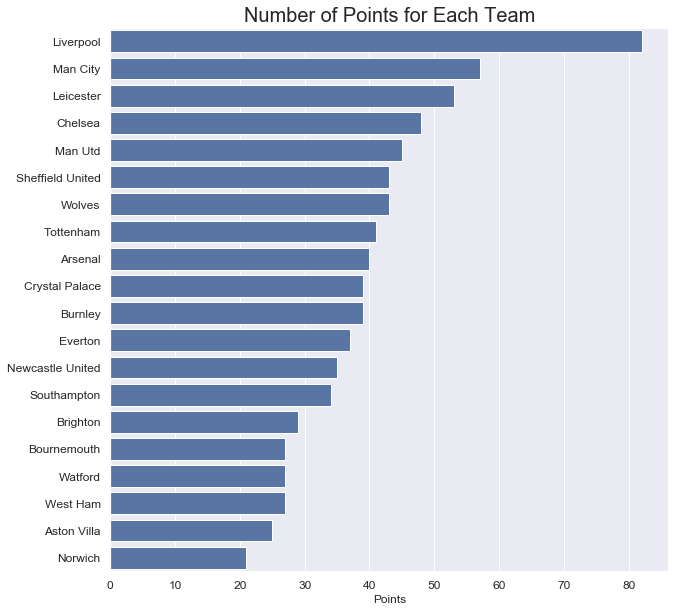

In [15]:
# Current Number of Points plot
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.barplot(x = 'tot_points', y = 'teamId', data = table, color = 'b')

ax.set_title("Number of Points for Each Team", fontsize = 20)
ax.set_xlabel('Points', fontsize = 12)
ax.set_ylabel('')
ax.tick_params(labelsize=12)

plt.show()

### 4.5: Which team has the most number of corners?<a name="corners"></a>

In [16]:
corners = epl.groupby('teamId', as_index = False).agg({"HC.x": "sum", "AC.x":"sum"})
corners['Total'] = corners['HC.x'] + corners['AC.x']
corners = corners.drop(columns = ['HC.x', 'AC.x'])
corners

,teamId,Total
0,Arsenal,344
1,Aston Villa,335
2,Bournemouth,339
3,Brighton,277
4,Burnley,307
5,Chelsea,296
6,Crystal Palace,324
7,Everton,308
8,Leicester,301
9,Liverpool,326


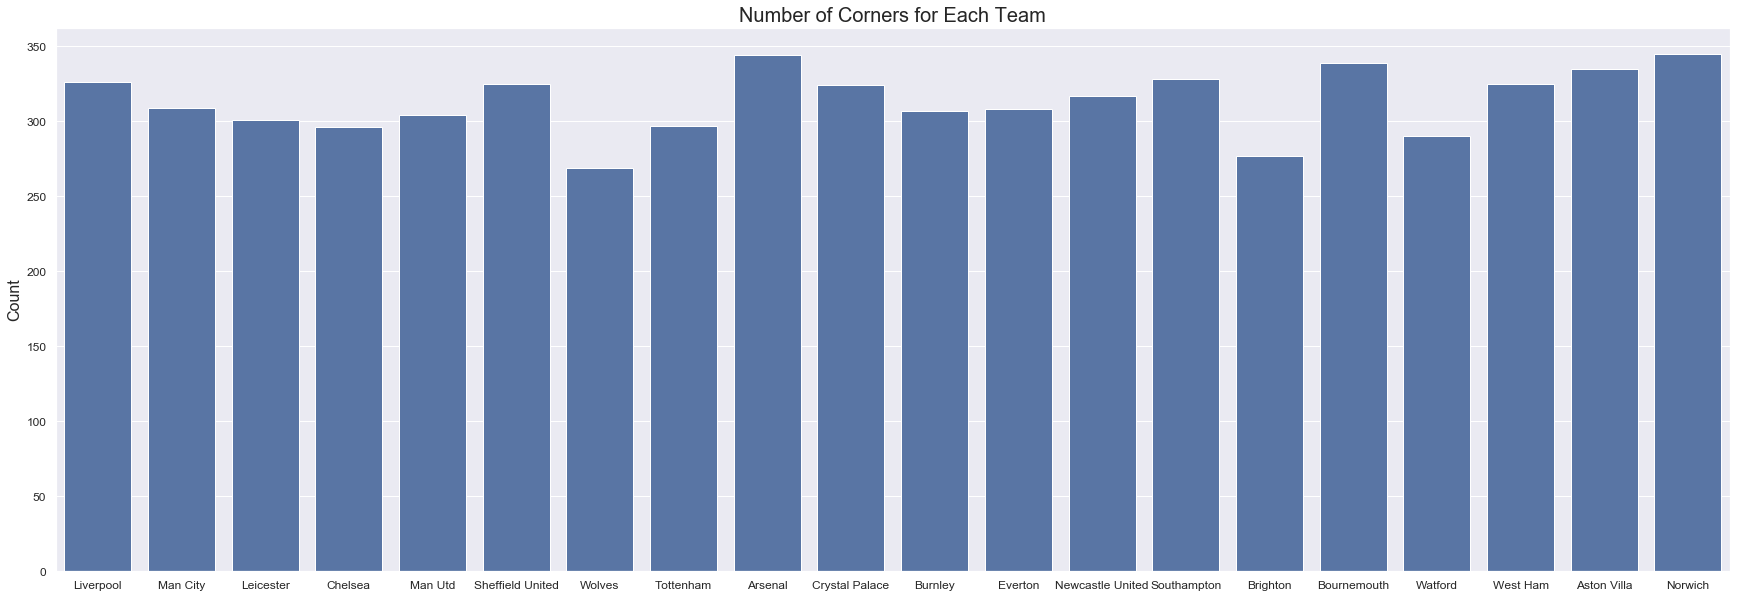

In [17]:
sns.set(rc={'figure.figsize':(30,10)})

ax = sns.barplot(x = "teamId", y = 'Total', data = corners, order = teams, color = 'b')
ax.set_title("Number of Corners for Each Team", fontsize = 20)
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize = 16)
ax.tick_params(labelsize=12)

plt.show()

### 4.6: What are the number of Wins, Losses, and Draws for each team?<a name="results"></a>

In [18]:
# Data behind the plot
results = epl.groupby('teamId')['result'].value_counts().to_frame()
results.columns = ['Count']
results

Count
teamId           result       
Arsenal          d          13
                 w           9
                 l           6
Aston Villa      l          17
                 w           7
                 d           4
Bournemouth      l          16
                 w           7
                 d           6
Brighton         l          12
                 d          11
                 w           6
Burnley          l          12
                 w          11
                 d           6
Chelsea          w          14
                 l           9
                 d           6
Crystal Palace   l          10
                 w          10
                 d           9
Everton          l          12
                 w          10
                 d           7
Leicester        w          16
                 l           8
                 d           5
Liverpool        w          27
                 d           1
                 l           1
Man City         w          18
                 l           7
                 d           3
Man Utd          w          12
                 d           9
                 l           8
Newcastle United l          12
                 w           9
                 d           8
Norwich          l          18
                 d           6
                 w           5
Sheffield United w          11
                 d          10
                 l           7
Southampton      l          15
                 w          10
                 d           4
Tottenham        w          11
                 l          10
                 d           8
Watford          l          14
                 d           9
                 w           6
West Ham         l          16
                 w           7
                 d           6
Wolves           d          13
                 w          10
                 l           6

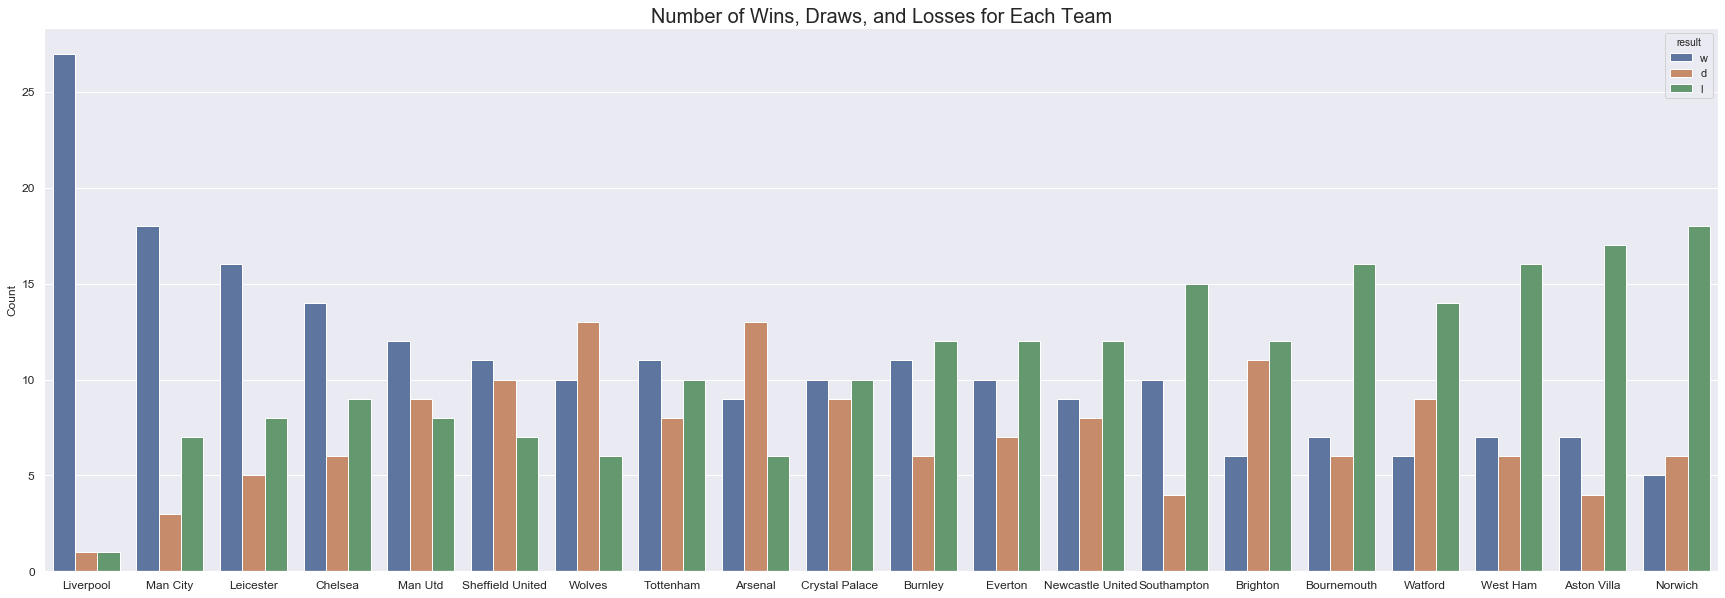

In [19]:
# Plot to show result counts per team
sns.set(rc={'figure.figsize':(30,10)})

ax = sns.countplot(x = "teamId", data = epl, hue = "result", order = teams, hue_order = ['w', 'd', 'l'],
             saturation = .65)
ax.set_title("Number of Wins, Draws, and Losses for Each Team", fontsize = 20)
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize = 12)
ax.tick_params(labelsize=12)

plt.show()

### 4.7: What are the number of goals scored and conceded for each team?<a name="goals"></a>

In [20]:
goals = epl.groupby('teamId').agg(
    Number_scored = pd.NamedAgg(column = 'tot_goal', aggfunc = max),
    Number_conceded = pd.NamedAgg(column = 'tot_con', aggfunc = max)).reset_index()
goals

,teamId,Number_scored,Number_conceded
0,Arsenal,40,36
1,Aston Villa,34,56
2,Bournemouth,29,47
3,Brighton,32,40
4,Burnley,34,40
5,Chelsea,51,39
6,Crystal Palace,26,32
7,Everton,37,46
8,Leicester,58,28
9,Liverpool,66,21


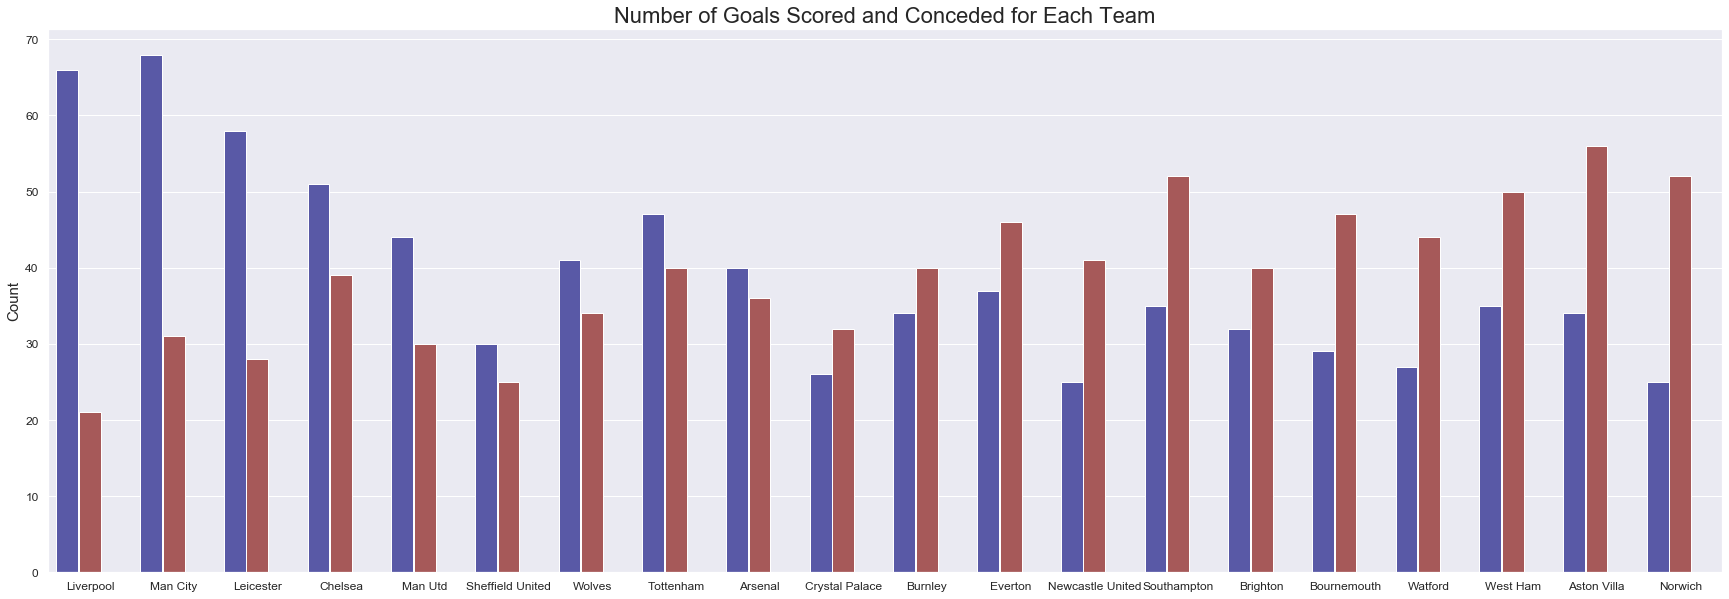

In [21]:
def change_width(ax, new_value,recenter=False) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        if recenter==True:  
            patch.set_x(patch.get_x() + diff * .5) #To recenter the bars

fig, ax1 = plt.subplots(figsize=(30, 10))

ax1 = sns.barplot(x = "teamId", data = goals, y = 'Number_scored', order = teams, color = 'blue', saturation = 0.3)
change_width(ax1, 0.26)

ax2 = sns.barplot(x = "teamId", data = goals, y = 'Number_conceded', order = teams, color = 'red', saturation = 0.3)
change_width(ax2, 0.26, True)

ax1.set_title("Number of Goals Scored and Conceded for Each Team", fontsize = 22)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize = 15)
ax1.tick_params(labelsize=12)

plt.show()

### 4.8: What are the counts for yellow and red cards for each team?<a name="cards"></a>

In [22]:
cards = epl.groupby('teamId', as_index = False).agg({"HY.x": "sum", "HR.x":"sum", "AY.x":"sum", "AR.x":"sum"})
cards['Yellows'] = cards['HY.x'] + cards['AY.x']
cards['Reds'] = cards['HR.x'] + cards['AR.x']
cards = cards.drop(columns = ['HY.x', 'HR.x', 'AY.x', 'AR.x'])
cards

,teamId,Yellows,Reds
0,Arsenal,122,3
1,Aston Villa,110,7
2,Bournemouth,111,5
3,Brighton,89,3
4,Burnley,93,1
5,Chelsea,114,2
6,Crystal Palace,114,6
7,Everton,101,5
8,Leicester,83,3
9,Liverpool,61,1


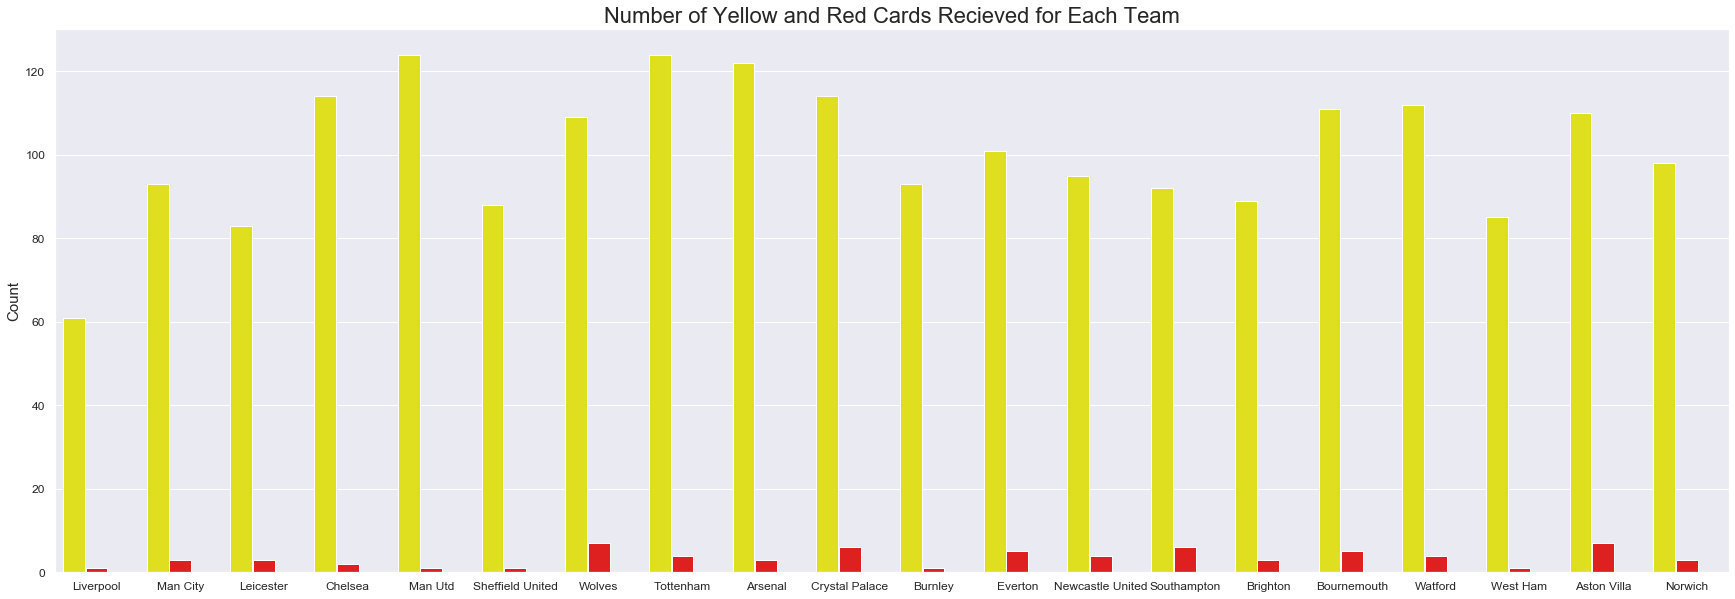

In [23]:
fig, ax1 = plt.subplots(figsize=(30, 10))

ax1 = sns.barplot(x = "teamId", data = cards, y = 'Yellows', order = teams, color = 'yellow')
change_width(ax1, 0.26)

ax2 = sns.barplot(x = "teamId", data = cards, y = 'Reds', order = teams, color = 'red')
change_width(ax2, 0.26, True)
 
ax1.set_title("Number of Yellow and Red Cards Recieved for Each Team", fontsize = 22)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize = 15)
ax1.tick_params(labelsize=12)

plt.show()

### 4.9: Are you more likely to gain points at your home ground vs away ground?<a name="ground"></a>

In [24]:
ground = epl.groupby(['teamId', 'h_a'], as_index = False)[['pts']].sum()
ground = ground.pivot_table(index = 'teamId', columns = 'h_a', values = 'pts').reset_index()
ground.columns = ['teamId','Away', 'Home']
ground

,teamId,Away,Home
0,Arsenal,14,26
1,Aston Villa,8,17
2,Bournemouth,10,17
3,Brighton,11,18
4,Burnley,16,23
5,Chelsea,24,24
6,Crystal Palace,17,22
7,Everton,12,25
8,Leicester,23,30
9,Liverpool,37,45


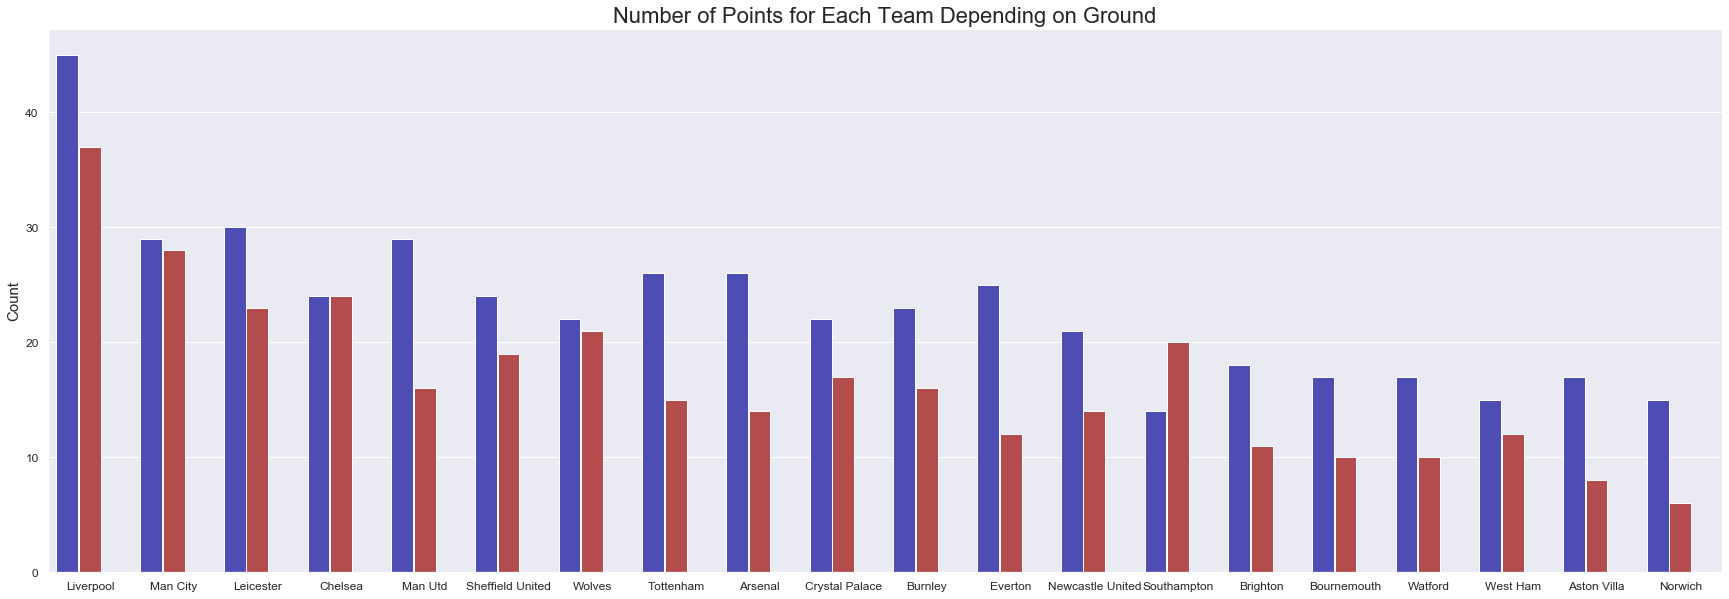

In [25]:
fig, ax1 = plt.subplots(figsize=(30, 10))

ax1 = sns.barplot(x = "teamId", data = ground, y = 'Home', order = teams, color = 'blue', saturation = 0.4)
change_width(ax1, 0.26)

ax2 = sns.barplot(x = "teamId", data = ground, y = 'Away', order = teams, color = 'red', saturation = 0.4)
change_width(ax2, 0.26, True)

ax1.set_title("Number of Points for Each Team Depending on Ground", fontsize = 22)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize = 15)
ax1.tick_params(labelsize=12)

plt.show()

 ***

## 5: Data Modelling<a name="modelling"></a>

#### Removing redundant/irrelevant features

- Referee should not have any difference in the result of the match. Therefore it has been ommitted. 
- teamId is currently a nominal feature. In order to avoid large dimensionality in the data, I engineered a numerical feature called 'position' based on a teams position in the table. This will aid the model in that a team located higher up in the table is more likely to win, and hence, the model is more likely to predict 'w' for the target feature and vice versa regarding teams located lower in the table.
- The 'pts' feature can now be removed. It remained in the dataset initially to aid data exploration. The 'pts' feature directly correlates to the target feature which would make the model redundant. 

In [26]:
def ranking(row):
    
    if row['teamId'] == 'Liverpool':
        val = 1
    elif row['teamId'] == 'Man City':
        val = 2
    elif row['teamId'] == 'Leicester':
        val = 3
    elif row['teamId'] == 'Chelsea':
        val = 4
    elif row['teamId'] == 'Man Utd':
        val = 5
    elif row['teamId'] == 'Wolves':
        val = 6
    elif row['teamId'] == 'Sheffield United':
        val = 7
    elif row['teamId'] == 'Tottenham':
        val = 8
    elif row['teamId'] == 'Arsenal':
        val = 9
    elif row['teamId'] == 'Crystal Palace':
        val = 10
    elif row['teamId'] == 'Burnley':
        val = 11
    elif row['teamId'] == 'Everton':
        val = 12
    elif row['teamId'] == 'Newcastle United':
        val = 13
    elif row['teamId'] == 'Southampton':
        val = 14
    elif row['teamId'] == 'Brighton':
        val = 15
    elif row['teamId'] == 'West Ham':
        val = 16
    elif row['teamId'] == 'Watford':
        val = 17
    elif row['teamId'] == 'Bournemouth':
        val = 18
    elif row['teamId'] == 'Aston Villa':
        val = 19
    else:
        val = 20
    return val

# Adding ranking column to epl dataframe
epl['position'] = epl.apply(ranking, axis = 1)

In [27]:
# Remove features which do not aid predictive modelling
epl = epl.drop(columns = ['pts', 'teamId', 'Referee.x'])

### 5.1: Data Preparation for Scikit Learn<a name="scikit"></a>

In [28]:
# Keep original dataset as is for future analysis
data_df = epl.copy()

# Create 'data' dataframe
data_df = data_df.drop(columns = 'result')

# Create 'target' dataframe
target_df = epl['result']

In [29]:
# Converting 'matchtime' to categorial feature
data_df['matchtime'] = data_df['matchtime'].astype('object')

In [30]:
# Encoding nominal descriptive features
categorical_cols = data_df.columns[data_df.dtypes == object].tolist()

for col in categorical_cols:
    n = len(data_df[col].unique())
    if (n == 2):
        data_df[col] = pd.get_dummies(data_df[col], drop_first = True)
        
data_df = pd.get_dummies(data_df)

In [31]:
# Encoding target feature
data_np = data_df.values
target_np = target_df.values

In [32]:
# LabelEncoder works alphabetically so d = 0, l = 1, w = 2
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le_fit = le.fit(target_np)
target_np = le_fit.transform(target_np)

In [33]:
# Scaling descriptive features
data_scaler = preprocessing.MinMaxScaler()
data_np = data_scaler.fit_transform(data_np)

In [34]:
data_df = pd.DataFrame(data_np, columns = data_df.columns)
data_df = data_df.assign(target = target_np)
data_df.head()

,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,npxGD,ppda_cal,allowed_ppda,tot_points,tot_goal,tot_con,HS.x,HST.x,HF.x,HC.x,HY.x,HR.x,AS.x,AST.x,AF.x,AC.x,AY.x,AR.x,B365H.x,B365D.x,B365A.x,HtrgPerc,AtrgPerc,h_a,position,matchtime_11,matchtime_12,matchtime_13,matchtime_14,matchtime_15,matchtime_16,matchtime_17,matchtime_18,matchtime_19,matchtime_20,matchDay_Fri,matchDay_Mon,matchDay_Sat,matchDay_Sun,matchDay_Thu,matchDay_Tue,matchDay_Wed,target
0,0.331555,0.119865,0.374954,0.135554,0.354839,0.161290,0.444444,0.111111,0.795618,0.625996,0.048471,0.321512,0.036585,0.058824,0.017857,0.428571,0.538462,0.428571,0.647059,0.000000,0.0,0.434783,0.333333,0.347826,0.1250,0.333333,0.0,0.005025,0.696970,0.718423,0.466667,0.416667,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.119865,0.331555,0.135554,0.374954,0.161290,0.354839,0.111111,0.444444,0.146759,0.374004,0.321512,0.048471,0.000000,0.014706,0.071429,0.428571,0.538462,0.428571,0.647059,0.000000,0.0,0.434783,0.333333,0.347826,0.1250,0.333333,0.0,0.005025,0.696970,0.718423,0.466667,0.416667,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.475892,0.174286,0.407297,0.197099,0.290323,0.032258,0.555556,0.000000,0.877284,0.610627,0.065943,0.232540,0.036585,0.073529,0.000000,0.071429,0.230769,0.285714,0.058824,0.333333,0.0,0.521739,0.600000,0.521739,0.0625,0.333333,0.0,0.784637,0.343434,0.003218,0.600000,0.642857,0.0,0.052632,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
3,0.174286,0.475892,0.197099,0.407297,0.032258,0.290323,0.000000,0.555556,0.083967,0.389373,0.232540,0.065943,0.000000,0.000000,0.089286,0.071429,0.230769,0.285714,0.058824,0.333333,0.0,0.521739,0.600000,0.521739,0.0625,0.333333,0.0,0.784637,0.343434,0.003218,0.600000,0.642857,1.0,0.789474,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,0.195679,0.234857,0.221292,0.265599,0.129032,0.193548,0.111111,0.111111,0.339069,0.476682,0.183254,0.104631,0.012195,0.014706,0.017857,0.357143,0.230769,0.476190,0.176471,0.333333,0.0,0.260870,0.200000,0.782609,0.2500,0.166667,0.0,0.063173,0.050505,0.098954,0.230769,0.375000,1.0,0.894737,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


- Original data set = 'epl' = DataFrame
- Normalised, encoded data set with target feature = 'data_df' = DataFrame
- sklearn data = 'data_np' = numpy array
- sklearn target = 'target_np' = numpy array

In [35]:
print(f"Original dataframe is 'epl' which is a {type(epl)} type")
print(f"Normalised, encoded dataframe with target feature is 'data_df' which is a {type(data_df)} type")
print(f"sklearn data is 'data_np' which is a {type(data_np)} type")
print(f'dimensions of data_np = {data_np.shape}')
print(f"sklearn target is 'target_np' which is a {type(target_np)} type")
print(f'dimensions of target_np = {target_np.shape}')

Original dataframe is 'epl' which is a <class 'pandas.core.frame.DataFrame'> type
Normalised, encoded dataframe with target feature is 'data_df' which is a <class 'pandas.core.frame.DataFrame'> type
sklearn data is 'data_np' which is a <class 'numpy.ndarray'> type
dimensions of data_np = (576, 51)
sklearn target is 'target_np' which is a <class 'numpy.ndarray'> type
dimensions of target_np = (576,)


In [189]:
# Split data into train and tests sets
from sklearn.model_selection import train_test_split

d_train, d_test, t_train, t_test = train_test_split(data_np, target_np, test_size = 0.3, 
                     stratify = target_np, shuffle = True, random_state = 999)

print(d_train.shape)
print(t_train.shape)
print(d_test.shape)
print(t_test.shape)

(403, 51)
(403,)
(173, 51)
(173,)


### 5.2: Feature Selection and Ranking<a name="selection"></a>

- All features
- F-score features
- Mutual Information features
- Random Forest importance features

#### 5.2.1: All features<a name="all"></a>

In [37]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.neighbors import KNeighborsClassifier

In [190]:
# Performance with all features, 5-knn
clf = KNeighborsClassifier(n_neighbors = 5)

clf.fit(d_train, t_train);

# stratified 5-fold cross validation with 3 repetitions
cv_method = RepeatedStratifiedKFold(n_splits = 5,
                                   n_repeats = 3,
                                   random_state = 999)

scoring_metric = 'accuracy'

cv_results_full = cross_val_score(estimator = clf,
                                 X = d_test,
                                 y = t_test,
                                 cv = cv_method,
                                 scoring = scoring_metric)

cv_results_full.mean().round(3)

0.414

With all features, and a k nearest neighbour model where n=5, the average accuracy is 53.1%

#### 5.2.2: F Score Features<a name="fscore"></a>

In [39]:
num_features = 5

fs_fit_fscore = fs.SelectKBest(fs.f_classif, k = num_features)
fs_fit_fscore.fit_transform(d_train, t_train)
fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:num_features]
best_features_fscore = data_df.columns[fs_indices_fscore].values
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]

In [40]:
import altair as alt

def plot_imp(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.75, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart

In [41]:
plot_imp(best_features_fscore, feature_importances_fscore, 'F-Score', 'red')

alt.Chart(...)

In [191]:
# Using just top 5 features based on f-score
cv_results_fscore = cross_val_score(estimator = clf,
                                 X = d_test[:,fs_indices_fscore],
                                 y = t_test,
                                 cv = cv_method,
                                 scoring = scoring_metric)
cv_results_fscore.mean().round(3)

0.821

#### 5.2.3: Mutual Information<a name="mutual"></a>

In [43]:
fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=num_features)
fs_fit_mutual_info.fit_transform(d_train, t_train)
fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:num_features]
best_features_mutual_info = data_df.columns[fs_indices_mutual_info].values
feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]
plot_imp(best_features_mutual_info, feature_importances_mutual_info, 'Mutual Information', 'blue')

alt.Chart(...)

In [192]:
cv_results_mutual_info = cross_val_score(estimator=clf,
                             X=d_test[:, fs_indices_mutual_info],
                             y=t_test, 
                             cv=cv_method, 
                             scoring=scoring_metric)
cv_results_mutual_info.mean().round(3)

0.819

#### 5.2.4: Random Forest<a name="forrest"></a>

In [45]:
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(d_train, t_train)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]
best_features_rfi = data_df.columns[fs_indices_rfi].values
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest', 'green')

alt.Chart(...)

In [193]:
cv_results_rfi = cross_val_score(estimator=clf,
                             X=d_test[:, fs_indices_rfi],
                             y=t_test, 
                             cv=cv_method, 
                             scoring=scoring_metric)
cv_results_rfi.mean().round(3)

0.84

#### 5.2.5: Performance comparison using paired t-tests<a name="ttest"></a>

In [47]:
print('Full Set of Features:', cv_results_full.mean().round(3))
print('F-Score:', cv_results_fscore.mean().round(3))
print('Mutual Information:', cv_results_mutual_info.mean().round(3))
print('RFI:', cv_results_rfi.mean().round(3))


Full Set of Features: 0.414
F-Score: 0.821
Mutual Information: 0.819
RFI: 0.84


In [48]:
from scipy import stats
print(stats.ttest_rel(cv_results_full, cv_results_fscore).pvalue.round(3))
print(stats.ttest_rel(cv_results_full, cv_results_mutual_info).pvalue.round(3))
print(stats.ttest_rel(cv_results_full, cv_results_rfi).pvalue.round(3))

0.0
0.0
0.0


In [51]:
# Selecting 5 best features based on RFI which gave us the best model results
d_train = d_train[:, fs_indices_rfi]
d_test = d_test[:, fs_indices_rfi]
print(d_test.shape)
print(d_train.shape)

(173, 5)
(403, 5)


### 5.3: Hyperparameter Tuning using 5 best features<a name="tuning"></a>

#### 5.3.1: KNN<a name="knn"></a>

In [63]:
params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 10, 20], 
              'p': [1, 2, 5]}

from sklearn.model_selection import GridSearchCV

gs_KNN = GridSearchCV(estimator = KNeighborsClassifier(), 
                      param_grid = params_KNN, 
                      cv = cv_method,
                      verbose = 1,
                      scoring = 'accuracy', 
                      return_train_score = True)
gs_KNN.fit(d_train, t_train);

Fitting 15 folds for each of 21 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:    6.2s finished
/Users/danielevans/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [65]:
print(gs_KNN.best_params_)
print(gs_KNN.best_score_)

{'n_neighbors': 1, 'p': 1}
0.9594706368899917


In [67]:
results_KNN = pd.DataFrame(gs_KNN.cv_results_['params'])
results_KNN['test_score'] = gs_KNN.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
results_KNN

,n_neighbors,p,test_score,metric
0,1,1,0.959471,Manhattan
1,1,2,0.953681,Euclidean
2,1,5,0.956989,Minkowski
3,2,1,0.909016,Manhattan
4,2,2,0.911497,Euclidean
5,2,5,0.926385,Minkowski
6,3,1,0.930521,Manhattan
7,3,2,0.923904,Euclidean
8,3,5,0.921423,Minkowski
9,4,1,0.904053,Manhattan


In [68]:
alt.Chart(results_KNN, 
          title='KNN Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('n_neighbors', title='Number of Neighbors'),
    alt.Y('test_score', title='Mean CV Score', scale=alt.Scale(zero=False)),
    color='metric'
)

alt.Chart(...)

#### 5.3.2: DT<a name="dt"></a>

In [86]:
from sklearn.tree import DecisionTreeClassifier

df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [2, 3, 4]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

gs_DT.fit(d_train, t_train);

Fitting 15 folds for each of 48 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    1.4s finished
/Users/danielevans/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [87]:
print(gs_DT.best_params_)
print(gs_DT.best_score_)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}
0.9983457402812241


In [88]:
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']
results_DT.columns


Index(['criterion', 'max_depth', 'min_samples_split', 'test_score'], dtype='object')

In [89]:
alt.Chart(results_DT, 
          title='DT Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('max_depth', title='Maximum Depth'),
    alt.Y('test_score', title='Mean CV Score', aggregate='average', scale=alt.Scale(zero=False)),
    color='criterion'
)

alt.Chart(...)

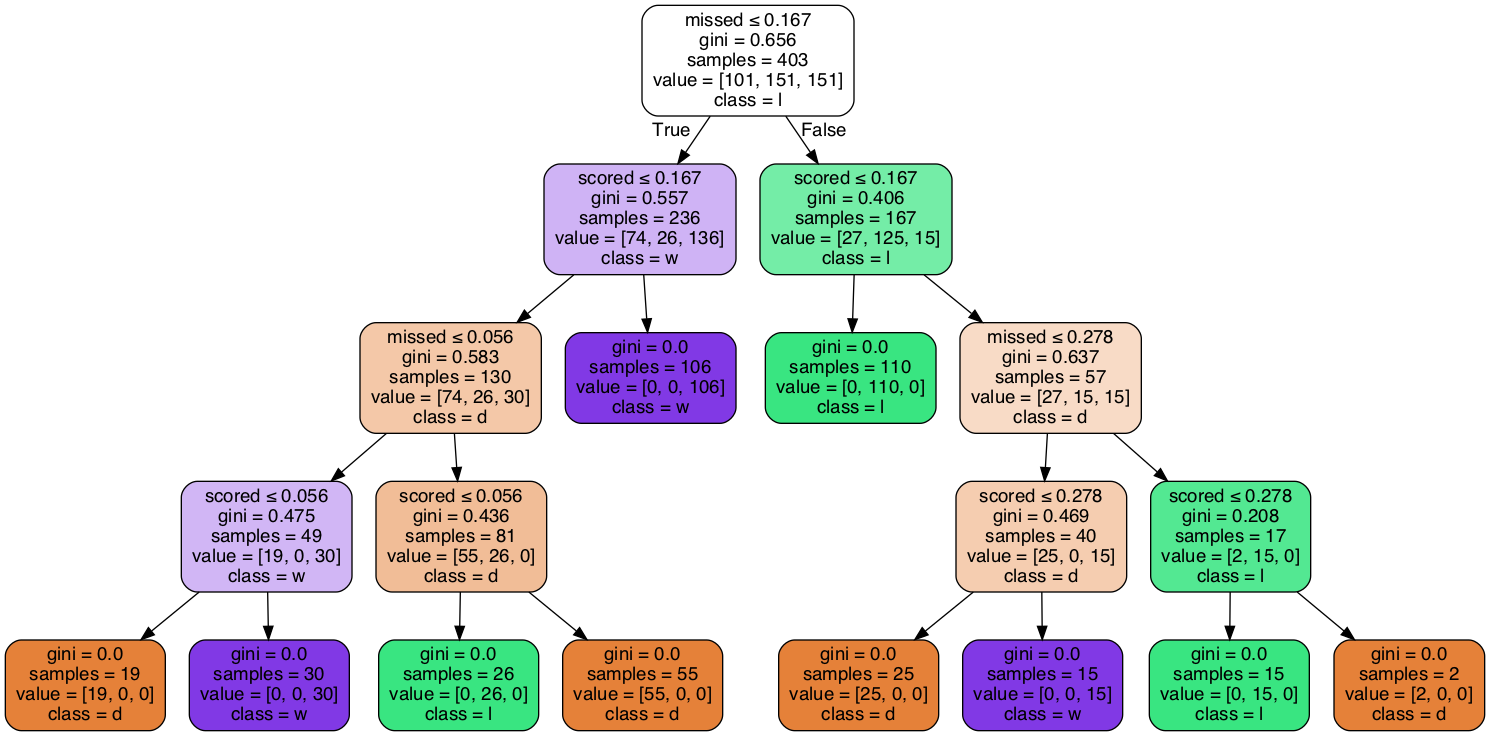

In [216]:
# Visual representation of decision tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
feature_cols = best_features_rfi.tolist()
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['d','l','w'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### 5.3.3: NB<a name="nb"></a>

In [91]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer

np.random.seed(999)

nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(d_train)

gs_NB.fit(Data_transformed, t_train);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    2.3s finished


In [92]:
print(gs_NB.best_params_)
print(gs_NB.best_score_)

{'var_smoothing': 0.008111308307896872}
0.7344913151364765


In [94]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']
alt.Chart(results_NB, 
          title='NB Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('var_smoothing', title='Var. Smoothing'),
    alt.Y('test_score', title='Mean CV Score', scale=alt.Scale(zero=False))
).interactive()

alt.Chart(...)

### 5.4: Performance Comparison<a name="comparison"></a>

Although multinomial classification is a generalization of the binary case, we cannot use the following binary metrics to evaluate a multinomial classifier:

- metrics.roc_auc_score.
- metrics.average_precision_score

In [174]:
# Knn where n = 1, p = 1
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors = 1, p = 1)
knn.fit(d_train, t_train)

cv_results_knn = cross_val_score(estimator = knn,
                                 X = d_test,
                                 y = t_test,
                                 cv = cv_method,
                                 scoring = scoring_metric)
cv_results_knn.mean().round(3)

0.89

In [175]:
# DT criterion = 'gini', max_depth = 4, min_samples_split = 2

dt = DecisionTreeClassifier(max_depth = 4, criterion = 'gini', min_samples_split = 2, random_state = 999)
dt.fit(d_train, t_train)

cv_results_dt = cross_val_score(estimator = dt,
                                 X = d_test,
                                 y = t_test,
                                 cv = cv_method,
                                 scoring = scoring_metric)
cv_results_dt.mean().round(3)

0.992

In [219]:
# NB 

nb = GaussianNB(var_smoothing = gs_NB.best_params_.get('var_smoothing'))

Data_transformed = PowerTransformer().fit_transform(d_test)


cv_results_nb = cross_val_score(estimator = nb,
                                 X = Data_transformed,
                                 y = t_test,
                                 cv = cv_method,
                                 scoring = 'accuracy')
cv_results_nb.mean().round(3)


0.578

In [178]:
from scipy import stats

print(stats.ttest_rel(cv_results_knn, cv_results_nb))
print(stats.ttest_rel(cv_results_dt, cv_results_knn))
print(stats.ttest_rel(cv_results_dt, cv_results_nb))

Ttest_relResult(statistic=9.337135350039716, pvalue=2.169544566455263e-07)
Ttest_relResult(statistic=6.078134285383729, pvalue=2.8468394286677674e-05)
Ttest_relResult(statistic=11.520190290429086, pvalue=1.576377683680928e-08)


In [181]:
pred_knn = knn.predict(d_test)

pred_dt = dt.predict(d_test)

pred_nb = nb.predict(d_test)

from sklearn import metrics
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(t_test, pred_knn))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(t_test, pred_dt))
print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(t_test, pred_nb))


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        43
           1       1.00      0.95      0.98        65
           2       0.93      1.00      0.96        65

    accuracy                           0.95       173
   macro avg       0.95      0.95      0.95       173
weighted avg       0.95      0.95      0.95       173


Classification report for Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        65
           2       1.00      1.00      1.00        65

    accuracy                           1.00       173
   macro avg       1.00      1.00      1.00       173
weighted avg       1.00      1.00      1.00       173


Classification report for Naive Bayes
              precision    recall  f1-score   support

           0       0.32      0.40      0.35        43
   

In [182]:
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(t_test, pred_knn))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(t_test, pred_dt))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(t_test, pred_nb))


Confusion matrix for K-Nearest Neighbor
[[38  0  5]
 [ 3 62  0]
 [ 0  0 65]]

Confusion matrix for Decision Tree
[[43  0  0]
 [ 0 65  0]
 [ 0  0 65]]

Confusion matrix for Naive Bayes
[[17 17  9]
 [16 49  0]
 [20  1 44]]


## 6: Critique of approach: underlying assumptions, limitations, strengths and weaknesses<a name="critique"></a>

## 7: Summary & Conclusions<a name="conclusions"></a>

***